In [1]:
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

## Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # 此處需要登入google帳號

Mounted at /content/gdrive


In [3]:
import pandas as pd
# 獲取授權碼之後輸入即可連動雲端硬碟
train = pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/files/model_train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/Statistical computing Final project/files/model_test.csv")
train.head()

,lemma_text,sentiment
0,menyrbie phil_gahan chrisitv,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock one empty please dont panic enough ...,Positive
4,ready go supermarket covid outbreak im paranoi...,Extremely Negative


## Model

In [4]:
train['lemma_text']=train['lemma_text'].astype(str)
test['lemma_text']=test['lemma_text'].astype(str)

In [5]:
# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train['label']=train['sentiment'].apply(lambda x:classes_def(x))
test['label']=test['sentiment'].apply(lambda x:classes_def(x))


train.label.value_counts(normalize= True)

2    0.438443
0    0.374080
1    0.187477
Name: label, dtype: float64

In [6]:
train.to_csv(r'/content/gdrive/MyDrive/Statistical computing Final project/files/model_train_with_label.csv', index = False, header=True)
test.to_csv(r'/content/gdrive/MyDrive/Statistical computing Final project/files/model_test_with_label.csv', index = False, header=True)

In [5]:
X = train["lemma_text"].tolist()
y = train["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.10,
                            random_state = 0)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                    
                        stop_words='english')

# We transform each text into a vector
features = tfidf.fit_transform(train['lemma_text']).toarray()

labels = train.label

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 41157 tweets is represented by 9433 features (TF-IDF score of unigrams and bigrams)


In [10]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [12]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.513605
1,RandomForestClassifier,1,0.504495
2,RandomForestClassifier,2,0.484510
3,RandomForestClassifier,3,0.471632
4,RandomForestClassifier,4,0.460211
5,LinearSVC,0,0.780491
6,LinearSVC,1,0.778183
7,LinearSVC,2,0.780221
8,LinearSVC,3,0.783987
9,LinearSVC,4,0.787632


In [11]:
cv_df.to_csv (r'/content/gdrive/MyDrive/Statistical computing Final project/files/cv_df.csv', index = False, header=True)

In [13]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.782103,0.003729
MultinomialNB,0.658162,0.004504
RandomForestClassifier,0.486891,0.022214


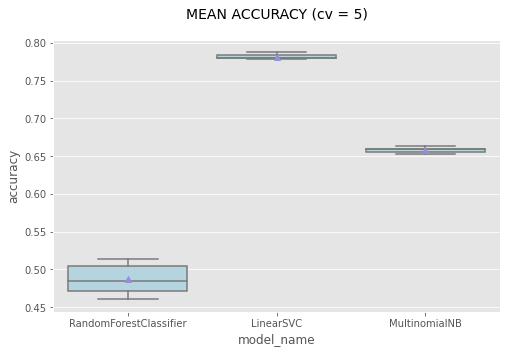

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [15]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train.index, test_size=0.10, 
                                                               random_state=1)
model =   LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
# Classification report

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train['label'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.81      0.80      0.80      1506
           2       0.68      0.64      0.66       766
           0       0.81      0.84      0.83      1844

    accuracy                           0.79      4116
   macro avg       0.77      0.76      0.76      4116
weighted avg       0.79      0.79      0.79      4116



In [17]:
# Create a new column 'category_id' with encoded categories 

def classes_def(x):
    if x ==  "Extremely Positive":
        return "Positive"
    elif x == "Extremely Negative":
        return "Negative"
    elif x == "Negative":
        return "Negative"
    elif x ==  "Positive":
        return "Positive"
    else:
        return "Neutral"
    

train['sentiment']=train['sentiment'].apply(lambda x:classes_def(x))


sentiment_id_df= train[["sentiment",'label']].drop_duplicates()

# Dictionaries for future use


sentiment_to_id = dict(sentiment_id_df.values)
id_to_sentiment = dict(sentiment_id_df[["sentiment",'label']].values)


sentiment_id_df

,sentiment,label
0,Neutral,1
1,Positive,2
4,Negative,0


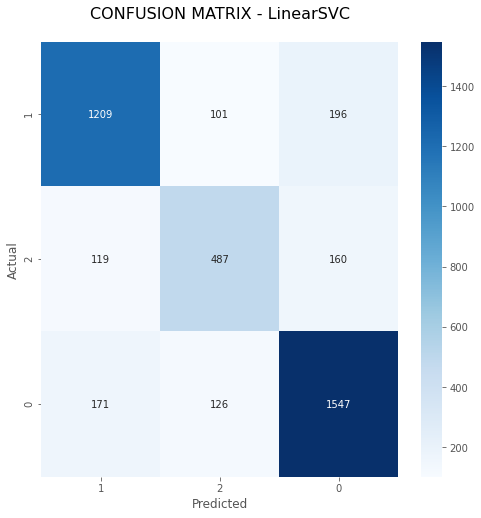

In [18]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=sentiment_id_df.label.values, 
            yticklabels=sentiment_id_df.label.values)
train = train.drop(columns=['sentiment'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.savefig(f"{images_dir}/Confusion matrix LinearSVC.png")
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);